In [ ]:
import uproot as up
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import re
import pandas as pd
from uproot3_methods.classes.TLorentzVector import TLorentzVector
from tqdm.notebook import tqdm
import pandas as pd

In [102]:
class rrFpy_pandas:
    def __init__(self, file_name):
        file = up.open(file_name)
        ntp = file["ntp"]
        df = pd.DataFrame(index = ak.to_pandas(ntp["pz"].array()).index, columns=["px", "py", "pz", "E", "Id"])
        df["px"] = ak.to_pandas(ntp["px"].array())
        df["py"] = ak.to_pandas(ntp["py"].array())
        df["pz"] = ak.to_pandas(ntp["pz"].array())
        df["E"] = ak.to_pandas(ntp["E"].array())
        df["Id"] = ak.to_pandas(ntp["Id"].array())
        df = df.reset_index()
        self.df_pivoted = pd.pivot_table(df, index = "entry", columns="subentry", values = ["px","py", "pz","E", "Id"])
        self.df_pivoted["nTrk"] = ak.to_pandas(ntp["nTrk"].array())
        self.df_pivoted["filter"] = True
        file.close()
    def sign(self, x):
        return -1 if x<0 else 1
    
    def parse_var(self, var):
        """
        parse_var(var): parses variables into name and list of particles
        """
        [name, numbers] = var.split("_")
        part_list = [int(n) for n in re.sub('([0-9])',r'\1 ',numbers.replace('m','-')).split(' ')[:-1]]
        return name, part_list
    
    def get_momDF_from_partList(self, part_list):
        """
        Constructs new dataFrame with 'px', 'py', 'pz', 'E' fields polulated with components of 
        total momentum that corresponds to part_list
        """
        df_res = pd.DataFrame(index=self.df_pivoted.index, columns = ["px","py","pz","E", "out"]).fillna(0)
        for i in part_list:
            abs_i = abs(i)
            for v in ["px","py","pz","E"]:
                df_res[v] += self.sign(i)*self.df_pivoted[v,abs_i]
        return df_res
        
    def __getitem__(self, key):
        """
        [var] operator: constructs the table of the variable for given dataset (taking cuts into account)
        """
        if type(key) == str:   # extract one var as a Series
            if key == "ntr":
                df_res = self.df_pivoted["nTrk"]
                df_res = df_res[ self.df_pivoted["filter"]]
                return df_res
            name, part_list = self.parse_var(key)
            mom_functions_dict =  {'m2': lambda t, x, y, z: t**2-x**2-y**2-z**2,
                'm': lambda t, x, y, z: np.sqrt(t**2-x**2-y**2-z**2),
                'pt2': lambda t, x, y, z: x**2+y**2,
                 'pt': lambda t, x, y, z: np.sqrt(x**2+y**2)};
            if name in mom_functions_dict.keys():
                func =mom_functions_dict[name]
                df_res = self.get_momDF_from_partList(part_list)
                df_res = df_res[ self.df_pivoted["filter"]]
                return func( df_res["E"], df_res["px"], df_res["py"], df_res["pz"])
            elif name == "id":
                df_res = self.df_pivoted["Id", abs(part_list[0])]
                df_res = df_res[ self.df_pivoted["filter"]]
                return df_res
        elif type(key) == list:  # exctract many vars and DataFrame
            df_all =  pd.concat([self[k] for k in key], axis=1)
            df_all.columns = key
            return df_all
    
    def reset_cuts(self):
        """
        Resets all filters set by previous cuts
        """
        self.df_pivoted["filter"] = True

    def cut(self, condition):
        """
        cut(condition): imposes a cut to the given dataset. Can be restored with reset_cuts
        """
        if type(condition) == str:
            condition = re.sub('([<>=])',r' \1 ', condition)
            var, operation, lhs = [s for s in condition.split(' ') if len(s)>0]
            if(operation == '>'):
                lhs = float(lhs)
                self.df_pivoted["filter"] = self.df_pivoted["filter"] & (self[var] > lhs) 
            elif operation == '<':
                lhs = float(lhs)
                self.df_pivoted["filter"] = self.df_pivoted["filter"] & (self[var] < lhs) 
            elif operation == '=':
                if '+-' in lhs:
                    lhs, error = [float(n) for n in lhs.split('+-')]
                else:
                    lhs = float(lhs)
                    error = 1e-3
                self.df_pivoted["filter"] = self.df_pivoted["filter"] & \
                    (self[var] > lhs - error) & (self[var] < lhs + error)
        elif type(condition) == list:
            for cond in condition:
                self.cut(cond)
        return np.count_nonzero(self.df_pivoted["filter"])

In [110]:
rrF = rrFpy_pandas("../build/evtOutput.root")

1.0000016604312472


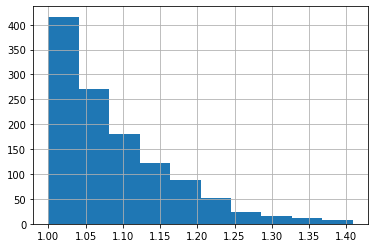

In [111]:
rrF.reset_cuts()
rrF.cut("m_12>1")
print(min(rrF["m_12"]))
rrF["m_12"].hist()
plt.show()

26870
-211.0


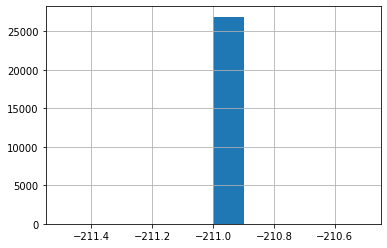

In [107]:
rrF.reset_cuts()
print(rrF.cut(["id_1=-211"]))
print(min(rrF["id_1"]))
rrF["id_1"].hist()
plt.show()

In [109]:
rrF["ntr"]

entry
0        5
2        5
3        5
4        5
8        5
        ..
99986    5
99990    5
99994    5
99995    5
99999    5
Name: nTrk, Length: 26870, dtype: int32

In [ ]:
rrF["ntr"].value_counts()

In [ ]:
rrF.reset_cuts()
rrF.cut("ntr=5")
rrF.cut("id_1=-211")

In [ ]:
rrF[["id_1"]]

In [ ]:
np.count_nonzero(rrF.df_pivoted["filter"])

In [ ]:
rrF[["id_1"]]

In [ ]:
rrF[['id_0','ntr']]

In [ ]:
rrF.cut("m_12>1")

In [ ]:
rrF["m_12"].hist(bins=100, histtype = 'step')
plt.show()

In [ ]:
rrF.reset_cuts()
rrF["m_12"].hist(bins=100, histtype = 'step')
plt.show()

In [ ]:
aa = rrF[["pt_1","pt_2","pt_3"]]
aa

In [ ]:
aa.plot.hist(bins=50, histtype = 'step')

In [ ]:
?aa.plot.hist